# Scenario 1
- Inputs: Simulator, 
- Query: Will Intervention keep hospitalizations below 3000?
- Intervention 1: Dec 1 - Mar 1, 5% decrease in transmission
- Intervention 2: Jan 1 - Mar 1, X% decrease required?

# Open Issues
1. Infected > Hospitalized, how is Hospitalized defined?
    - Assume that H = I * HR, HR = hospitalization rate, maybe synthesize HR
2. Initial Conditions?  
    - From Data.  

# Goals
1. Synthesize (X, Start Intervention)
2. Synthesize (HR, gamma, End of Intervention)
3. Models: CHIME, BUCKY, CHIME SVIIR

# Analysis:
1. Intervention 1 works (yes/no), Intervention 2 (range of X that works, single variable synthesis)
2. Compute a metric: I1: sum of differences with threshold, I2: uniform grid evaluation of sum of differences.
3. Additional Parameters: HR, Start of Intervention, 
4. Sensitivity Analysis: What values of infection rate will the intervention work or not.  

# Operations:
- evaluate point
- project onto subset of dimensions
- project after assigning dimensions 
- Evaluate metric over remaining space

In [1]:
from model2smtlib.bilayer.translate import BilayerEncoder, BilayerEncodingOptions
from funman.scenario.consistency import ConsistencyScenario
from funman.scenario.parameter_synthesis import ParameterSynthesisScenario
from funman import Funman
from funman.model import Parameter, QueryLE, QueryTrue
from funman.model.bilayer import Bilayer, BilayerMeasurement, BilayerModel
from funman.search_utils import SearchConfig
from funman_demo.handlers import ResultCacheWriter, RealtimeResultPlotter, NotebookImageRefresher
from funman.search_utils import ResultCombinedHandler, SearchConfig
import os
import tempfile

%load_ext autoreload
%autoreload 2

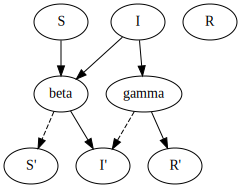

In [2]:
# Define the dynamics with a bilayer

chime_bilayer_src = {
    "Wa": [{"influx": 1, "infusion": 2}, {"influx": 2, "infusion": 3}],
    "Win": [
        {"arg": 1, "call": 1},
        {"arg": 2, "call": 1},
        {"arg": 2, "call": 2},
    ],
    "Box": [{"parameter": "beta"}, {"parameter": "gamma"}],
    "Qin": [{"variable": "S"}, {"variable": "I"}, {"variable": "R"}],
    "Qout": [{"tanvar": "S'"}, {"tanvar": "I'"}, {"tanvar": "R'"}],
    "Wn": [{"efflux": 1, "effusion": 1}, {"efflux": 2, "effusion": 2}],
}

chime_bilayer = Bilayer.from_json(chime_bilayer_src)
chime_bilayer.to_dot()

In [3]:
# Define the measurements made of the bilayer variables

measurements = {
    "state" : [{"variable": "I"}],
    "observable" : [{"observable" : "H"}],
    "rate" : [{"parameter": "hr"}],
    "Din": [{"variable": 1, "parameter": 1}],
    "Dout": [{"parameter": 1, "observable": 1}]
}
hospital_measurements = BilayerMeasurement.from_json(measurements)
hospital_measurements.to_dot()

In [4]:
# Model Setup for both Intervention 1
# - Prescribed reduction in transmission

transmission_reduction = 0.05
duration = 120 #days
model = BilayerModel(
    chime_bilayer,
    measurements = hospital_measurements,
    init_values={"S": 10000, "I": 1, "R": 1},
    parameter_bounds={
        # "beta": [0.00067*(1.0-transmission_reduction), 0.00067*(1.0-transmission_reduction)],
        "beta" : [0.00005, 0.00007],
        "gamma": [1.0/14.0, 1.0/14.0],
        "hr": [0.05, 0.05]
    },
)
# query = QueryLE("I", 9000) # TODO change to H after incorporating measurement encoding
query = QueryTrue()

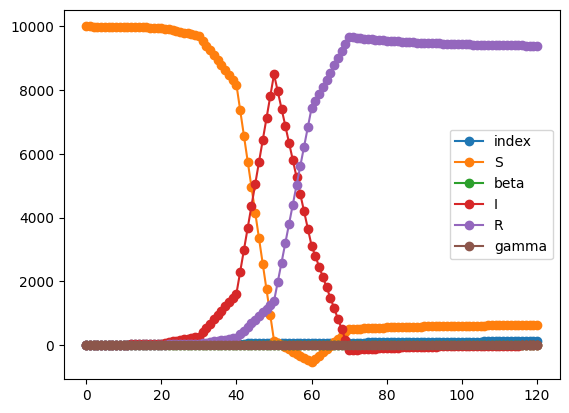

parameters = {'beta': 1/16384, 'gamma': 2573485501354569/36028797018963968}
     index             S      beta          I            R     gamma
0        0  10000.000000  0.000061   1.000000     1.000000  0.071429
1        1   9999.389648  0.000061   1.538923     1.071429  0.071429
2        2   9998.779297  0.000061   2.077846     1.142857  0.071429
3        3   9998.168945  0.000061   2.616769     1.214286  0.071429
4        4   9997.558594  0.000061   3.155692     1.285714  0.071429
..     ...           ...       ...        ...          ...       ...
116    116    618.931621  0.000061 -19.560436  9402.628816  0.071429
117    117    619.851564  0.000061 -18.725283  9400.873719  0.071429
118    118    620.771508  0.000061 -17.890131  9399.118622  0.071429
119    119    621.691452  0.000061 -17.054978  9397.363526  0.071429
120    120    622.611396  0.000061 -16.219826  9395.608429  0.071429

[121 rows x 6 columns]


In [5]:
# Analyze Intervention 1 to check it will achieve goals of query

tmp_dir_path = tempfile.mkdtemp(prefix="funman-")
result = Funman().solve(
    ConsistencyScenario(
        model,
        query,
        smt_encoder=BilayerEncoder(config=BilayerEncodingOptions(step_size=10, max_steps=duration)) # four months
    )
)
if result.consistent:
    result.plot()
    print(f"parameters = {result.parameters()}")
    print(result.dataframe())
else:
    print("Scenario Inconsistent")

In [6]:
# Model Setup for both Intervention 2
# - unknown efficacy

transmission_reduction = 0.05
model = BilayerModel(
    chime_bilayer,
    measurements = hospital_measurements,
    init_values={"S": 10000, "I": 1, "R": 1},
    parameter_bounds={
        "beta": [0.0, 1.0], # beta no longer prescribed
        "gamma": [1.0/14.0, 1.0/14.0],
        "hr": [0.05, 0.05]
    },
)


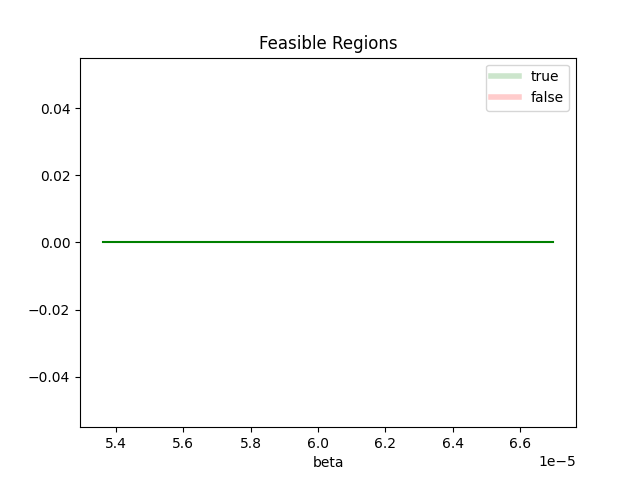

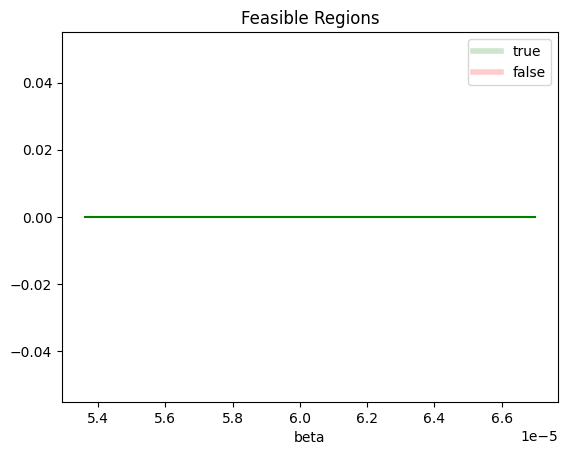

In [7]:
# Intervention 2 is over a shorter time period, with different initial conditions
# The task is to find the level of efficacy beta needed to satisfy the query

# The efficacy can be up to 4x that of baseline (i.e., 0.05 - 0.20)
parameters = [
    Parameter("beta", lb=0.000067*(1.0-4*transmission_reduction), ub=0.000067)
]
tmp_dir_path = tempfile.mkdtemp(prefix="funman-")
result = Funman().solve(
    ParameterSynthesisScenario(
        parameters,
        model,
        query,
        smt_encoder=BilayerEncoder(config=BilayerEncodingOptions(step_size=30, max_steps=3*30))
    ),
    config=SearchConfig(
        number_of_processes=1,
        tolerance=1e-6,
        wait_action = NotebookImageRefresher(os.path.join(tmp_dir_path, "search.png"), sleep_for=1),
        handler=ResultCombinedHandler(
            [
                ResultCacheWriter(os.path.join(tmp_dir_path, "search.json")),
                RealtimeResultPlotter(
                    parameters,
                    plot_points=True,
                    realtime_save_path=os.path.join(tmp_dir_path, "search.png"),
                ),
            ]
        ),
    ),
)
result.plot()

<!-- (:process infection
 :parameters (?gamma)
 :precondition (and)
 :effect (and 
            (increase (I) (function1))
            (increase (R) (function2))
            (increase (S) (function3))
            )
 )

 (:durative-action mandate
  :parameters ()
  :duraiton (?duration)
  :precondition (and)
  :effect (and (at-start (increase (beta) (function1))
                (at-end (decrease (beta) (function1))))
  )

  (:event infected-threshold
   :precondtion (>= I 1000)
   :effect (fail)
   ) -->

# Scneario 2
- Inputs:
    - Query: Rate of vaccination to keep cases under threshold over period of time
    - Result: Compute minimum vacc rate
- Parameters:
    - Vaccination rate
    - Age range (optional)
    - Age specific efficacy

# Scenario 3
- Identify indifference region wrt. parameters.
- Outside of indifference region are candidate parameters where one model is better.
- Generate two parameter spaces, identify symm diff, and evaluate metric over symm diff uniform grid.  Metric can be the fit to data.

In [8]:
# Notes in this cell

# chime_bilayer_src = {
#     "Wa": [{"influx": 1, "infusion": 2}, {"influx": 2, "infusion": 3}],
#     "Win": [
#         {"arg": 1, "call": 1},
#         {"arg": 2, "call": 1},
#         {"arg": 2, "call": 2},
#     ],
#     "Box": [{"parameter": "beta"}, {"parameter": "gamma"}],
#     "Qin": [{"variable": "S"}, {"variable": "I"}, {"variable": "R"}],
#     "Qout": [{"tanvar": "S'"}, {"tanvar": "I'"}, {"tanvar": "R'"}],
#     "Wn": [{"efflux": 1, "effusion": 1}, {"efflux": 2, "effusion": 2}],
# }

# measurements = {
#     "S" : [{"variable": "I"}],
#     "O" : [{"observable" : "H"}],
#     "D" : [{"parameter": "hr"}],
#     "Din": [{"variable": 1, "parameter": 1}],
#     "Dout": [{"parameter": 1, "observable": 1}]
# }

# chime_bilayer = Bilayer.from_json(chime_bilayer_src, measurements)


# chime_bilayer_src2 = {
#     "Wa": [{"influx": 1, "infusion": 2}, {"influx": 2, "infusion": 3}],
#     "Win": [
#         {"arg": 1, "call": 1},
#         {"arg": 2, "call": 1},
#         {"arg": 2, "call": 2},
#     ],
#     "Box": [{"parameter": "beta"}, {"parameter": "gamma"}],
#     "Qin": [{"variable": "S"}, {"variable": "I"}, {"variable": "R"}],
#     "Qout": [{"tanvar": "S'"}, {"tanvar": "I'"}, {"tanvar": "R'"}],
#     "Wn": [{"efflux": 1, "effusion": 1}, {"efflux": 2, "effusion": 2}],
# }

# measurements2 = {
#     "S" : [{"variable": "I"}],
#     "O" : [{"observable" : "H"}],
#     "D" : [{"parameter": "hr"}],
#     "Din": [{"variable": 1, "parameter": 1}],
#     "Dout": [{"parameter": 1, "observable": 1}]
# }
# chime_bilayer2 = Bilayer.from_json(chime_bilayer_src2, measurements2)

# fail = Bilayer.from_json({}, {})
# HybridAutomaton(
#     [Node(chime_bilayer, QueryLE(chime_bilayer, "I", 1000)), Node(chime_bilayer2, QueryLE(chime_bilayer, "I", 1000)), Node(fail, None)],
#     [Jump(chime_bilayer, Guard(QueryLE(chime_bilayer, "days", 10)),chime_bilayer2)]
#     )

# chime_bilayer = Bilayer.from_json(chime_bilayer_src, measurements)
# chime_bilayer.to_dot()
